In [1]:
'''
Modified from https://github.com/pytorch/vision.git
'''
import math

import torch.nn as nn
import torch.nn.init as init

__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
}


def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))
net = vgg11()

In [2]:
#download mnist and #
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import os
import cv2
from torchvision import transforms

EPOCH = 10  
BATCH_SIZE = 200
LR = 0.001  


train_data = torchvision.datasets.MNIST(
    root='./data/',  
    train=True,  
    transform=transforms.ToTensor(),
    download=True,  
)


train_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True  
)

test_data = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
)

test_x = torch.unsqueeze(test_data.train_data, dim=1).type(torch.FloatTensor)/255
test_y = test_data.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [3]:
resize = transforms.Resize([32,32])
test_x=resize(test_x)
test_x = test_x.expand(-1, 3, -1, -1)

In [4]:
test_x.shape

torch.Size([10000, 3, 32, 32])

In [5]:
import time

print_every_batch=50

optimizer = torch.optim.Adam(net.parameters(), lr=LR)

loss_func = nn.CrossEntropyLoss()  

list_lost=[]
list_accuracy=[]
list_epoch_time=[]

for epoch in range(EPOCH):
    epoch_start_time = time.time()
    for batch_id, (batch_x, batch_y) in enumerate(train_loader):
        batch_x=resize(batch_x)
        batch_x = batch_x.expand(-1, 3, -1, -1)
        output = net(batch_x)  
        loss = loss_func(output, batch_y)  
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  

        
        if batch_id % print_every_batch == 0:
            test_output = net(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
            list_lost.append(loss.data.numpy())
            list_accuracy.append(accuracy)
            
    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print("Epoch %d of %d with %.2f s" % (epoch + 1, EPOCH, per_epoch_ptime))
    list_epoch_time.append(per_epoch_ptime)

Epoch:  0 | train loss: 2.2998 | test accuracy: 0.10
Epoch:  0 | train loss: 1.8607 | test accuracy: 0.43
Epoch:  0 | train loss: 0.3569 | test accuracy: 0.88
Epoch:  0 | train loss: 0.2281 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1320 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0336 | test accuracy: 0.98
Epoch 1 of 10 with 279.63 s
Epoch:  1 | train loss: 0.0569 | test accuracy: 0.98
Epoch:  1 | train loss: 0.0481 | test accuracy: 0.98
Epoch:  1 | train loss: 0.0430 | test accuracy: 0.99
Epoch:  1 | train loss: 0.0184 | test accuracy: 0.99
Epoch:  1 | train loss: 0.0710 | test accuracy: 0.98
Epoch:  1 | train loss: 0.0393 | test accuracy: 0.99
Epoch 2 of 10 with 278.90 s
Epoch:  2 | train loss: 0.0380 | test accuracy: 0.99
Epoch:  2 | train loss: 0.0356 | test accuracy: 0.99
Epoch:  2 | train loss: 0.0505 | test accuracy: 0.98
Epoch:  2 | train loss: 0.0125 | test accuracy: 0.99
Epoch:  2 | train loss: 0.0404 | test accuracy: 0.97
Epoch:  2 | train loss: 0.0281 | test accur

In [6]:
import numpy as np
lost_array=np.array(list_lost)
list_accuracy=np.array(list_accuracy)
list_epoch_time=np.array(list_epoch_time)

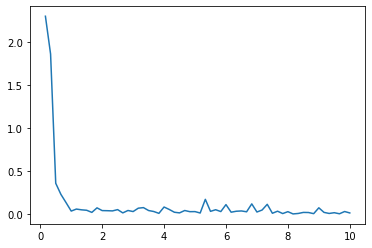

In [7]:
plt.plot(np.array(list(range(1,61)))/6,lost_array)

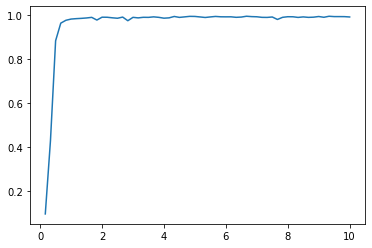

In [8]:
plt.plot(np.array(list(range(1,61)))/6,list_accuracy)

In [9]:
sum(list_epoch_time)/10

287.233229136467

In [10]:
torch.save(net, "vgg.pth")  

In [11]:
model = torch.load("vgg.pth")
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [12]:
test_output = model(test_x)
pred_y = torch.max(test_output, 1)[1].data.numpy()
accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

Epoch:  9 | train loss: 0.0919 | test accuracy: 0.99


In [13]:
pred_y=pred_y.tolist()
test_y=test_y.tolist()

In [14]:
for i in range(1000):
    
    if pred_y[i]!=test_y[i]:
        print(i)

62
115
321
445
449
495
659
674
726
728
738
900
938
965


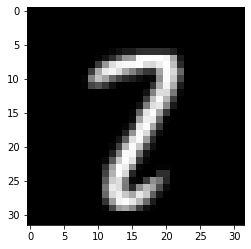

In [15]:
plt.imshow(test_x[321,0,:,:],cmap='gray')

In [16]:
pred_y[321]

7

In [17]:
test_y[321]

2